In [ ]:
conda activate U4-S1-NLP
jupyter lab

Lambda School Data Science

*Unit 4, Sprint 1, Module 2*

---

# Vector Representations (Prepare)


As we learned yesterday, machines cannot interpret raw text. We need to transform that text into something we/machines can more readily analyze. Yesterday, we did simple counts of counts to summarize the content of Amazon reviews. Today, we'll extend those concepts to talk about vector representations such as Bag of Words (BoW) and word embedding models. We'll use those representations for search, visualization, and prepare for our classification day tomorrow. 

Processing text data to prepare it for machine learning models often means translating the information from documents into a numerical format. Bag-of-Words approaches (sometimes referred to as Frequency-Based word embeddings) accomplish this by "vectorizing" tokenized documents. This is done by representing each document as a row in a DataFrame and creating a column for each unique word in the corpora (group of documents). The presence or lack of a given word in a document is then represented either as a raw count of how many times a given word appears in a document (CountVectorizer) or as that word's TF-IDF score (TfidfVectorizer).

On the python side, we will be focusing on `sklearn` and `spacy` today.  

## Case Study

We're going to pretend we're on the datascience team at the BBC. We want to recommend articles to visitors to on the BBC website based on the article they just read. Our team wants 

**Dataset:**

[D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.](http://mlg.ucd.ie/datasets/bbc.html)
*Please note that the dataset has been sampled down to tech articles only.* 

## Learning Objectives
* <a href="#p1">Part 1</a>: Represent a document as a vector
* <a href="#p2">Part 2</a>: Query Documents by Similarity
* <a href="#p3">Part 3</a>: Apply word embedding models to create document vectors

### Let's start with an analogy

![](https://peterbeshai.com/static/d9c3868cc1becd7648da453597a5d616/36dbb/DER_cube.jpg)

Pretend that the objecting floating in the room is our raw text dataset (i.e. a collection of documents). 

A vectorizer is a mathamatical transformation that takes our raw text data and transforms it into a numerical representation (i.e. numbers inside of vectors). 

Depending on which vectorizer you use, you will be capturing some of the information encoded in the text but not other information. 

So, as the analogy goes, depending which side of the floating object you stand and shine a light from, you will only see a portion of the information that exists in your text data set. Apply one vectorizer and you'll get word counts but not the contextual meaning; apply another vectorizer and you'll get the contextual meaning of the words but not the counts. 

**Take Away:** Understand the benefits and limitations of using each of the vectorizers that we'll be learning today. 

----

# Represent a document as a vector (Learn)
<a id="p1"></a>

## Overview

In this section, we are going to create Document Term Matrices (DTM). Each column represents a word. Each row represents a document. The value in each cell can be range of different things. The most traditional: counts of appearances of words, does the word appear at all (binary), and term-frequency inverse-document frequency (TF-IDF). 

**Discussion:** Don't we loose all the context and grammar if we do this? So Why does it work?

## Follow Along

In [1]:
""" Import Statements """

# Classics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import spacy
nlp = spacy.load("en_core_web_md", disable=['parser', 'tagger', 'ner'])

**Warm Up (_3 Minutes_)**

Extract the tokens from this sentence using Spacy. Text is from [OpenAI](https://openai.com/blog/better-language-models/)

In [2]:
text = """GPT-2 displays a broad set of capabilities, including the ability to generate conditional synthetic text samples of 
unprecedented quality, where we prime the model with an input and have it generate a lengthy continuation. In addition, GPT-2 
outperforms other language models trained on specific domains (like Wikipedia, news, or books) without needing to use these 
domain-specific training datasets. On language tasks like question answering, reading comprehension, summarization, and 
translation, GPT-2 begins to learn these tasks from the raw text, using no task-specific training data. While scores on these 
downstream tasks are far from state-of-the-art, they suggest that the tasks can benefit from unsupervised techniques, given 
sufficient (unlabeled) data and compute."""

In [3]:
def tokenizer(text):

    doc = nlp(text)

    # Create a list of tokens using nlp and the sample string "text"
    tokens = []

    # iterate through the tokens in the doc
    for token in doc:

        # create a couple of filters for low quality tokens 
        if (token.is_stop != True) and (token.is_punct != True):
            # save case normalized lemmas to token list 
            tokens.append(token.lemma_.lower())
            
    return tokens

In [4]:
tokenizer(text)

C:\Users\somer\miniconda3\envs\DeepLearning\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


['gpt-2',
 'displays',
 'broad',
 'set',
 'capabilities',
 'including',
 'ability',
 'generate',
 'conditional',
 'synthetic',
 'text',
 'samples',
 '\n',
 'unprecedented',
 'quality',
 'prime',
 'model',
 'input',
 'generate',
 'lengthy',
 'continuation',
 'addition',
 'gpt-2',
 '\n',
 'outperforms',
 'language',
 'models',
 'trained',
 'specific',
 'domains',
 'like',
 'wikipedia',
 'news',
 'books',
 'needing',
 'use',
 '\n',
 'domain',
 'specific',
 'training',
 'datasets',
 'language',
 'tasks',
 'like',
 'question',
 'answering',
 'reading',
 'comprehension',
 'summarization',
 '\n',
 'translation',
 'gpt-2',
 'begins',
 'learn',
 'tasks',
 'raw',
 'text',
 'task',
 'specific',
 'training',
 'data',
 'scores',
 '\n',
 'downstream',
 'tasks',
 'far',
 'state',
 'art',
 'suggest',
 'tasks',
 'benefit',
 'unsupervised',
 'techniques',
 'given',
 '\n',
 'sufficient',
 'unlabeled',
 'data',
 'compute']

In [5]:
import os 

def gather_data(filefolder):
    """ Produces List of Documents from a Directory
    
    filefolder (str): a path of .txt files
    
    returns list of strings 
    """
    
    data = []
    
    files = os.listdir(filefolder) # Causes variation across machines
    
    for article in files: 
        
        path = os.path.join(filefolder, article)
                    
        if  path[-3:] == 'txt': # os ~endswith('txt')
            with open(path, 'rb') as f:
                data.append(f.read())
    
    return data

In [6]:
data = gather_data('./data')
print(f'Number of Documents: {len(data)}')

Number of Documents: 401


In [7]:
data[0]

b'Ink helps drive democracy in Asia\n\nThe Kyrgyz Republic, a small, mountainous state of the former Soviet republic, is using invisible ink and ultraviolet readers in the country\'s elections as part of a drive to prevent multiple voting.\n\nThis new technology is causing both worries and guarded optimism among different sectors of the population. In an effort to live up to its reputation in the 1990s as "an island of democracy", the Kyrgyz President, Askar Akaev, pushed through the law requiring the use of ink during the upcoming Parliamentary and Presidential elections. The US government agreed to fund all expenses associated with this decision.\n\nThe Kyrgyz Republic is seen by many experts as backsliding from the high point it reached in the mid-1990s with a hastily pushed through referendum in 2003, reducing the legislative branch to one chamber with 75 deputies. The use of ink is only one part of a general effort to show commitment towards more open elections - the German Embass

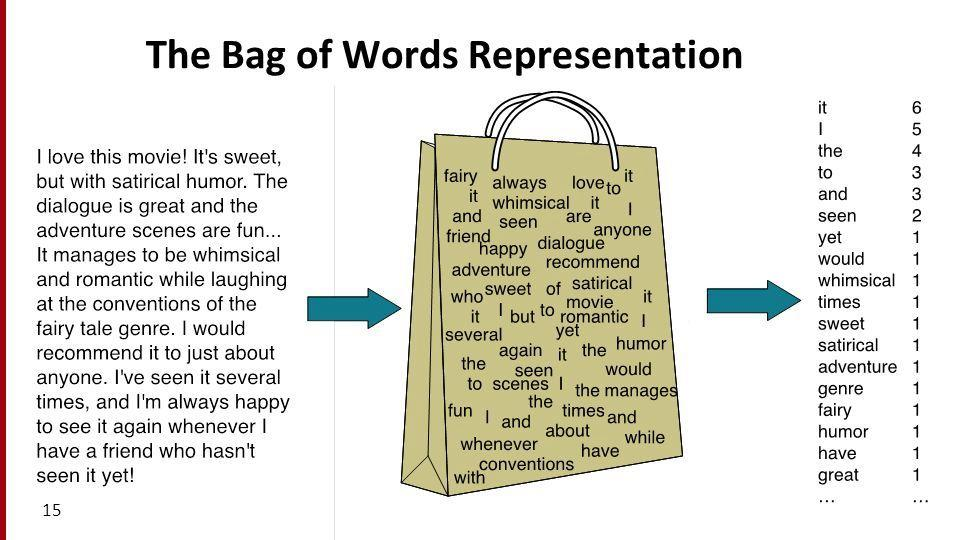-----
# CountVectorizer

![](https://images4.programmersought.com/947/0a/0acb9279d17a1631bcfb154583cca443.JPEG)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer


# list of text documents
text = ["We created a new dataset which emphasizes diversity of content, by scraping content from the Internet.",
        "In order to preserve document quality, we used only pages which have been curated/filtered by humans—specifically, we used outbound links from Reddit which received at least 3 karma.",
        "This can be thought of as a heuristic indicator for whether other users found the link interesting (whether educational or funny), leading to higher data quality than other similar datasets, such as CommonCrawl."]

# create the transformer  # Instantiate
vect = CountVectorizer()

# build vocab
vect.fit(text)

# transform text
# dtm stands for Doc-Term Matrix 
dtm = vect.transform(text)

In [9]:
dtm

<3x61 sparse matrix of type '<class 'numpy.int64'>'
	with 69 stored elements in Compressed Sparse Row format>

In [10]:
# number of documents x unique words

In [11]:
# .todense() or .toarray() moves the dtm out of the sprase representation and into more of an familar array rep.
dtm.todense()

matrix([[0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
         0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
         1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 2],
        [2, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
         1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 2, 0,
         0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0]],
       dtype=int64)

In [12]:
# This is sparse format.  It doesnt make a space for every possibility.  I cant explain.
# row 0 column 4 = 1
# row 0 column 7 = 2

In [13]:
print(dtm)  # It will only store the non-zero entries. Look above and compare to below here. 
# This is helpful when there are a million rows.  

  (0, 4)	1
  (0, 7)	2
  (0, 8)	1
  (0, 11)	1
  (0, 13)	1
  (0, 16)	1
  (0, 20)	1
  (0, 29)	1
  (0, 35)	1
  (0, 36)	1
  (0, 47)	1
  (0, 52)	1
  (0, 58)	1
  (0, 60)	1
  (1, 1)	1
  (1, 3)	1
  (1, 4)	1
  (1, 9)	1
  (1, 14)	1
  (1, 17)	1
  (1, 20)	1
  (1, 22)	1
  (1, 25)	1
  (1, 26)	1
  (1, 30)	1
  :	:
  (2, 10)	1
  (2, 12)	1
  (2, 15)	1
  (2, 18)	1
  (2, 19)	1
  (2, 21)	1
  (2, 23)	1
  (2, 24)	1
  (2, 27)	1
  (2, 28)	1
  (2, 31)	1
  (2, 33)	1
  (2, 36)	1
  (2, 38)	1
  (2, 40)	2
  (2, 44)	1
  (2, 48)	1
  (2, 50)	1
  (2, 51)	1
  (2, 52)	1
  (2, 53)	1
  (2, 54)	1
  (2, 55)	1
  (2, 57)	1
  (2, 59)	2


In [14]:
dir(dtm)

['__abs__',
 '__add__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__idiv__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmatmul__',
 '__rmul__',
 '__round__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_add_dense',
 '_add_sparse',
 '_arg_min_or_max',
 '_arg_min_or_max_axis',
 '_ascontainer',
 '_asindices',
 '_binopt',
 '_bsr_container',
 '_container',
 '_coo_container',
 '_cs_matrix__get_has_canonical_format',
 '_cs_ma

In [15]:
vect.get_feature_names()

C:\Users\somer\miniconda3\envs\DeepLearning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['as',
 'at',
 'be',
 'been',
 'by',
 'can',
 'commoncrawl',
 'content',
 'created',
 'curated',
 'data',
 'dataset',
 'datasets',
 'diversity',
 'document',
 'educational',
 'emphasizes',
 'filtered',
 'for',
 'found',
 'from',
 'funny',
 'have',
 'heuristic',
 'higher',
 'humans',
 'in',
 'indicator',
 'interesting',
 'internet',
 'karma',
 'leading',
 'least',
 'link',
 'links',
 'new',
 'of',
 'only',
 'or',
 'order',
 'other',
 'outbound',
 'pages',
 'preserve',
 'quality',
 'received',
 'reddit',
 'scraping',
 'similar',
 'specifically',
 'such',
 'than',
 'the',
 'this',
 'thought',
 'to',
 'used',
 'users',
 'we',
 'whether',
 'which']

In [16]:
text[0]

'We created a new dataset which emphasizes diversity of content, by scraping content from the Internet.'

In [17]:
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
print(dtm.shape)

(3, 61)


**Three Minute Challenge:** 
* Apply CountVectorizer to our BBC Data
* Store results in a dataframe called `dtm`
* Extra Challenge - Try to Customize CountVectorizer with Spacy Processing

In [18]:
import re
# You can create your own tokenizer or use Spacy.
# But Spacy leaves a lot by default.  You add if(token.is_alpha == True) for instance.
def simple_tokenizer(text):
    clean_text = re.sub('[^a-zA-Z ]','', text)
    tokens = clean_text.lower().split()
    
    # Future: Add stemming and Lemma 
    return tokens
#  He doesnt use count vectorizer but uses tfidf

In [ ]:
def simple_tokenizer2(text):
    """Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out by the mechanics of your choice."""
    lower = text.lower()
    lower_no_punc = re.sub('[^a-z 0-9]', '', lower)
    tokens = lower_no_punc.split
    
    return tokens

In [19]:
# for token in doc:
#     ...

In [20]:
# instantiate a countvector object
# vect = CountVectorizer()
vect = CountVectorizer(stop_words='english',
                       ngram_range=(1,3),  # looking for words occuring together i think
                       min_df=3,           # Rare words, these are far more common. statistical trimming - ignore words that happen < 2 
                       max_df=0.25,  # Its a percent if a decimal and a number otherwise. Ignore the words that appear in a ton of docs.
                       tokenizer=simple_tokenizer)         # or you can use 0.3 (30%) to get rid of common words like Amazon (usually 25-70%)
                                           # changing these makes huge differences. I must play with.
# Learn our Vocab
vect.fit(data)

# Get sparse dtm (i.e. transform the data)
dtm = vect.transform(data)

dtm = pd.DataFrame(data=dtm.toarray(), columns= vect.get_feature_names())
print(dtm.shape)
dtm.head()

C:\Users\somer\miniconda3\envs\DeepLearning\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(401, 8414)


C:\Users\somer\miniconda3\envs\DeepLearning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ability,ability record,able access,able choose,able control,able handle,able make,able offer,able play,able use,...,youngsters,youre,youth,youve,zelda,zen,zen micro,zombies,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# let's try to create a bag-of-words model using our custom tokenizer 

# instantiate a countvector object
# vect = CountVectorizer(tokenizer=tokenizer)  # scikit-learn.org 
vect = CountVectorizer(stop_words='english',
                       min_df=2) # statistical trimming - ignore words that happen < 2 or you can use 0.1

                        # I MESSED UP HERE!!!

# Learn our Vocab
vect.fit(data)

# Get sparse dtm (i.e. transform the data)
dtm_with_tokenizer = vect.transform(data)

dtm_with_tokenizer = pd.DataFrame(data=dtm_with_tokenizer.toarray(), columns= vect.get_feature_names())
print(dtm_with_tokenizer.shape)
dtm_with_tokenizer.head()

(401, 7172)


C:\Users\somer\miniconda3\envs\DeepLearning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,000,080,10,100,100m,101,102,104,106,10m,...,zenith,zens,zero,zip,zodiac,zombies,zone,zones,zoom,zooms
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# TfidfVectorizer

## Term Frequency - Inverse Document Frequency (TF-IDF)

![](https://miro.medium.com/max/1404/1*mu6G-cBmWlENS4pWHEnGcg@2x.jpeg)


**Term Frequency:** The count of token i in document j 

**Document Frequency:** A penalty for the token existing in a high number of documents.

The purpose of TF-IDF is to find what is **unique** to each document. Because of this we will penalize the term frequencies of words that are common across all documents which will allow for each document's most different topics to rise to the top.


![](https://upload.wikimedia.org/wikipedia/commons/8/81/Logarithm_plots.png)

It's useful to reference both the algebraic and geometric representations of a single mathematical ideal whenever possible in order to build the fullest understanding possible. 

The IDf portion of the TF-IDF equation has been coded up below so that we can play around with the values and get a better understanding of how this portion of the equation works. 

NOTE: There are many different ways that one could choose to construct the equation for the IDF term, don't let that trip you up; different constructions of the equation serve different purposes and which you ultimately use simply depends on your problem/task. You can [check out a few different ways to build that IDF term here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In practice, you usually don't even have to think about the mathematical formulation of the IDF term. You simply import the tfidf vectorizer and use it's api. The rare exception to this would if you are working a very particular kind of problem where the open source implementation of tfidf doesn't suit your needs and so then you might consider creating your own equation or using a different one that you read about. 

In [22]:
# inverse document frequency score 
# the plus ones are constants that shift the around the baseline value 
def idf(n, df):
    """
    Parameters
    ----------
    n: int
        num of docs in corpus 
        
    df: int
        num of docs that term t (i.e. a token) appears in 

    Returns
    -------
    inverse docuemnt frequency: float
    """
    return np.log( (n + 1)/ (df + 1))

In [23]:
n = 100 # num of docs in corpus 
df_range = 100
idf_list = []

# mention why we are not starting the count at 0 
for df in range(0, df_range + 1):
    idf_score = idf(n, df)
    idf_list.append(idf_score)

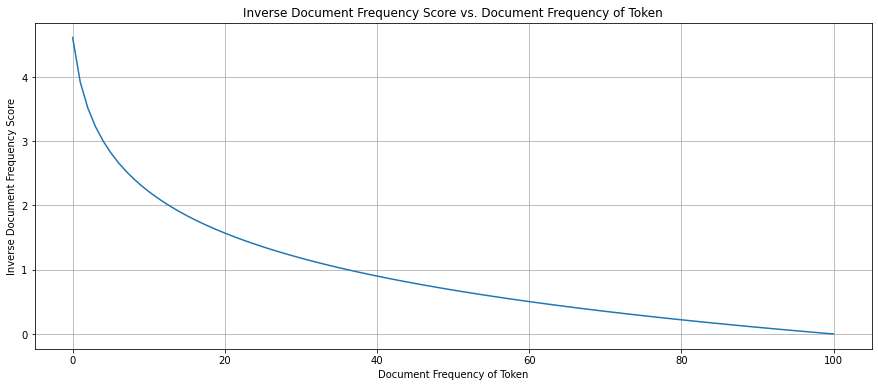

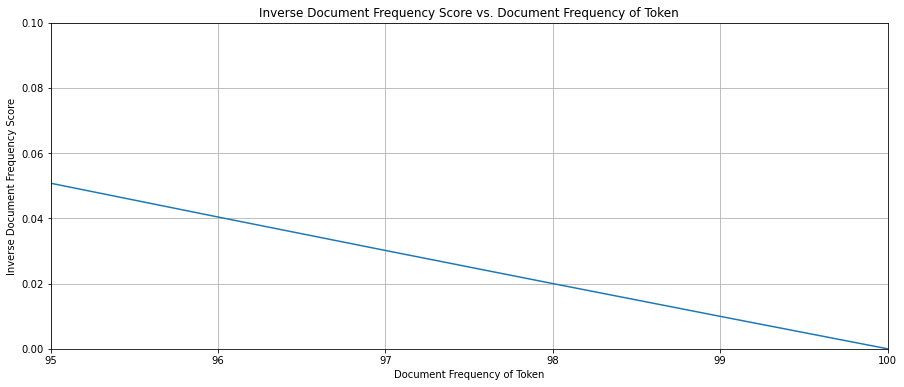

In [24]:
plt.figure(figsize=(15,6))
plt.title("Inverse Document Frequency Score vs. Document Frequency of Token")
plt.ylabel("Inverse Document Frequency Score")
plt.xlabel("Document Frequency of Token")
plt.grid()
plt.plot(idf_list);
plt.show()

plt.figure(figsize=(15,6))
plt.title("Inverse Document Frequency Score vs. Document Frequency of Token")
plt.ylabel("Inverse Document Frequency Score")
plt.xlabel("Document Frequency of Token")
plt.xlim(95,100)
plt.ylim(0,0.10)
plt.grid()
plt.plot(idf_list);
plt.show()

In [25]:
# let's work through a couple of examples to help build intuition 

# imagine the token we are considering is "purchase" and it rare appears
n = 100 # num of docs in corpus

tf = 3 # this is the term-freq of purchase in doc j 
df = 10 # this is the number of docs that the token purchase appears in 

tfidf_score = tf * idf(n, df)
tfidf_score

6.651675732128667

In [26]:
# imagine the token that we are considering is "the" and it appears often

tf = 50 # this is the term-freq of the in doc j 
df = 95 # this is the number of docs that the token the appears in 

tfidf_score = tf * idf(n, df)
tfidf_score

# it creates a more meaningful vector

2.538616268671157

Now that we have built some intuition on how tfidf works, let's use sklearn's implementations to vectorizer our dataset. 

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
vect = TfidfVectorizer(stop_words='english',
                       ngram_range=(1,3),  # looking for words occuring together i think
                       min_df=3,           # statistical trimming - ignore words that happen < 2 
                       max_df=0.5,
                       tokenizer=simple_tokenizer)         # or you can use 0.3 (30%) to get rid of common words like Amazon (usually 25-70%)
                                           # changing these makes huge differences. I must play with.
# Learn our Vocab
vect.fit(data)

# Get sparse dtm (i.e. transform the data)
dtm_with_tokenizer = vect.transform(data)

dtm_with_tokenizer = pd.DataFrame(data=dtm_with_tokenizer.toarray(), columns= vect.get_feature_names())
print(dtm_with_tokenizer.shape)
dtm_with_tokenizer.head()
# Create a vocabulary and get word counts per document


C:\Users\somer\miniconda3\envs\DeepLearning\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(401, 8457)


C:\Users\somer\miniconda3\envs\DeepLearning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ability,ability record,able,able access,able choose,able control,able handle,able make,able offer,able play,...,youngsters,youre,youth,youve,zelda,zen,zen micro,zombies,zone,zoom
0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.04832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
dtm_with_tokenizer.describe()

,ability,ability record,able,able access,able choose,able control,able handle,able make,able offer,able play,...,youngsters,youre,youth,youve,zelda,zen,zen micro,zombies,zone,zoom
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,...,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,0.004174,0.000345,0.009314,0.001090,0.000570,0.000521,0.000556,0.001090,0.000434,0.000359,...,0.000552,0.001776,0.000694,0.000328,0.000543,0.000799,0.000428,0.001169,0.000471,0.000437
std,0.013274,0.003989,0.019053,0.010143,0.006676,0.006039,0.006414,0.011239,0.005051,0.004183,...,0.005537,0.012826,0.006223,0.004031,0.006264,0.008386,0.004944,0.010464,0.005495,0.005161
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.019055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.086671,0.051584,0.124402,0.117526,0.085675,0.074181,0.076497,0.136375,0.063272,0.057447,...,0.063749,0.201043,0.064155,0.062356,0.074905,0.105996,0.061305,0.103176,0.071234,0.076244


In [29]:
dtm_with_tokenizer.sum(axis=0).sort_values(ascending=False)

mobile          11.162454
games           10.295243
mr               9.602247
music            9.038703
technology       8.908203
                  ...    
tin              0.109415
subsequently     0.106306
couch potato     0.098217
couch            0.098217
potato           0.098217
Length: 8457, dtype: float64

In [30]:
# Instantiate vectorizer object
tfidf = TfidfVectorizer(ngram_range=(1, 2))

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(data)

dtm = pd.DataFrame(data=dtm.toarray(), columns=tfidf.get_feature_names())

C:\Users\somer\miniconda3\envs\DeepLearning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Challenge

During this module's project assignment, you will transform data science job listings to vector representations for analysis downstream. 

# Query Documents by Similarity (Learn)
<a id="p2"></a>

## Overview

Have you ever considered how a search bar works? You may just think that search bars simply match your input text againist the documents. While there are many different mechanisms for the 'match', one of the most classic is to search by similarity. We will apply n-dimensional distance to measure similarity, and query for input and output. 

## Follow Along

### Cosine Similarity (Brute Force)

In [31]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate Distance of TF-IDF Vectors
dist_matrix = cosine_similarity(dtm)

# Turn it into a DataFrame
df = pd.DataFrame(dist_matrix)
print(df.shape)

(401, 401)


In [32]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,1.000000,0.078184,0.044378,0.090911,0.112935,0.121886,0.060665,0.087308,0.140444,0.069561,...,0.090385,0.063570,0.112144,0.133429,0.103048,0.058858,0.070456,0.135994,0.067559,0.133571
1,0.078184,1.000000,0.037980,0.086570,0.088666,0.097624,0.044336,0.063036,0.107208,0.060447,...,0.086913,0.076182,0.092436,0.104109,0.081588,0.067733,0.077278,0.103032,0.060034,0.118551
2,0.044378,0.037980,1.000000,0.052267,0.067233,0.061323,0.130887,0.142193,0.067965,0.091253,...,0.043948,0.054771,0.088976,0.081105,0.059602,0.060431,0.076105,0.073732,0.052787,0.076470
3,0.090911,0.086570,0.052267,1.000000,0.119686,0.120961,0.066221,0.077993,0.163198,0.084756,...,0.091186,0.069109,0.138192,0.146077,0.127384,0.067872,0.070172,0.132464,0.079469,0.161173
4,0.112935,0.088666,0.067233,0.119686,1.000000,0.142465,0.069799,0.098821,0.160630,0.094501,...,0.129269,0.094230,0.164336,0.189393,0.171583,0.101486,0.089068,0.164296,0.084321,0.193841


In [33]:
# Grab the row and pick off the indicies of the most/least similar docs
df[0].sort_values(ascending=False)[1:10]

332    0.180173
36     0.163320
378    0.147431
8      0.140444
398    0.135994
400    0.133571
394    0.133429
318    0.131970
163    0.126438
Name: 0, dtype: float64

In [34]:
data[0][0:500]

b'Ink helps drive democracy in Asia\n\nThe Kyrgyz Republic, a small, mountainous state of the former Soviet republic, is using invisible ink and ultraviolet readers in the country\'s elections as part of a drive to prevent multiple voting.\n\nThis new technology is causing both worries and guarded optimism among different sectors of the population. In an effort to live up to its reputation in the 1990s as "an island of democracy", the Kyrgyz President, Askar Akaev, pushed through the law requiring the '

In [35]:
data[332][0:500]

b"US woman sues over ink cartridges\n\nA US woman is suing Hewlett Packard (HP), saying its printer ink cartridges are secretly programmed to expire on a certain date.\n\nThe unnamed woman from Georgia says that a chip inside the cartridge tells the printer that it needs re-filling even when it does not. The lawsuit seeks to represent anyone in the US who has purchased an HP inkjet printer since February 2001. HP, the world's biggest printer firm, declined to comment on the lawsuit. HP ink cartridges "

In [36]:
# Subtract the TF-IDF vectors for document 0 and 332
# Show me all the non-zeros...
# I need to go over this very much.
# This is about a recommendation engine
# It doesnt always make sense to do Brute Force (if big?) instead try below

### NearestNeighbor (K-NN) 
![](https://miro.medium.com/max/753/0*jqxx3-dJqFjXD6FA)


Nearest Neighbor models are distance based algorithms. They store your training set in memory. 

When you want to find the nearest neighbors for a point in your test set, then simply calculate the distance of the nearest k points. 

So instead of calculating the every single possible distance between all points (i.e. **Brute Force** ) , NN models only calculate the nearest k distances. 

In [37]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5, algorithm="kd_tree")

# Fit on DTM
nn.fit(dtm)

# sample a doc from dtm to use as our query point 
doc_index = 0
doc_vector = [dtm.iloc[doc_index]]

# Query Using kneighbors 
neigh_dist, neigh_ind = nn.kneighbors(doc_vector)  # show the the nn to this one vector
# the default is the minkowski distance (metric:str or callable: the distance metric to use for a tree... scikit-learn.org
# pyfunc

C:\Users\somer\miniconda3\envs\DeepLearning\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [38]:
neigh_dist

array([[0.        , 1.28048989, 1.29358418, 1.3058091 , 1.31114922]])

In [39]:
neigh_ind  # here you can see 0, 332 ?? what is the meaning?? I need to research the hell out of this
#pickling you can save a conditon without training as part of your pipeline...make model portable. 
# https://transformer.huggingface.co/doc/gpt2-large
# https://github.com/huggingface/transformers
# http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
# https://spacy.io/models/en
# https://nlp.stanford.edu/projects/glove/

array([[  0, 332,  36, 378,   8]], dtype=int64)

## Challenge

In the module project assignment, you will apply one of these search techniques to retrieve documents related to a query document. 

# Apply word embedding models to create document vectors (Learn)
<a id="p3"></a>

## Overview
### BoW discards textual context

One of the limitations of Bag-of-Words approaches is that any information about the textual context surrounding that word is lost. This also means that with bag-of-words approaches often the only tools that we have for identifying words with similar usage or meaning and subsequently consolidating them into a single vector is through the processes of stemming and lemmatization which tend to be quite limited at consolidating words unless the two words are very close in their spelling or in their root parts-of-speech.

### Embedding approaches preserve more textual context
Word2Vec is an increasingly popular word embedding technique. Like Bag-of-words it learns a real-value vector representation for a predefined fixed-size vocabulary that is generated from a corpus of text. However, in contrast to BoW, Word2Vec approaches are much more capable of accounting for textual context, and are better at discovering words with similar meanings or usages (semantic or syntactic similarity).

### Word2Vec Intuition
### The Distribution Hypothesis

In order to understand how Word2Vec preserves textual context we have to understand what's called the Distribution Hypothesis (Reference: Distribution Hypothesis Theory  -https://en.wikipedia.org/wiki/Distributional_semantics. The Distribution Hypothesis operates under the assumption that words that have similar contexts will have similar meanings. Practically speaking, this means that if two words are found to have similar words both to the right and to the left of them throughout the corpora then those words have the same context and are assumed to have the same meaning. 

> "You shall know a word by the company it keeps" - John Firth

This means that we let the usage of a word define its meaning and its "similarity" to other words. In the following example, which words would you say have a similar meaning? 

**Sentence 1**: Traffic was light today

**Sentence 2**: Traffic was heavy yesterday

**Sentence 3**: Prediction is that traffic will be smooth-flowing tomorrow since it is a national holiday

What words in the above sentences seem to have a similar meaning if all you knew about them was the context in which they appeared above? 

Lets take a look at how this might work in action, the following example is simplified, but will give you an idea of the intuition for how this works.

#### Corpora:

1) "It was the sunniest of days."

2) "It was the raniest of days."

#### Vocabulary:

{"it": 1, "was": 2, "the": 3, "of": 4, "days": 5, "sunniest": 6, "raniest": 7}

### Vectorization

|       doc   | START_was | it_the | was_sunniest | the_of | sunniest_days | of_it | days_was | it_the | was_raniest | raniest_days | of_END |
|----------|-----------|--------|--------------|--------|---------------|-------|----------|--------|-------------|--------------|--------|
| it       | 1         | 0      | 0            | 0      | 0             | 0     | 1        | 0      | 0           | 0            | 0      |
| was      | 0         | 1      | 0            | 0      | 0             | 0     | 0        | 1      | 0           | 0            | 0      |
| the      | 0         | 0      | 1            | 0      | 0             | 0     | 0        | 0      | 1           | 0            | 0      |
| sunniest | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0      | 0           | 0            | 0      |
| of       | 0         | 0      | 0            | 0      | 1             | 0     | 0        | 0      | 0           | 1            | 0      |
| days     | 0         | 0      | 0            | 0      | 0             | 0     | 0        | 0      | 0           | 0            | 1      |
| raniest  | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0      | 0           | 0            | 0      |

Each column vector represents the word's context -in this case defined by the words to the left and right of the center word. How far we look to the left and right of a given word is referred to as our "window of context." Each row vector represents the the different usages of a given word. Word2Vec can consider a larger context than only words that are immediately to the left and right of a given word, but we're going to keep our window of context small for this example. What's most important is that this vectorization has translated our documents from a text representation to a numeric one in a way that preserves information about the underlying context. 

We can see that words that have a similar context will have similar row-vector representations, but before looking that more in-depth, lets simplify our vectorization slightly. You'll notice that we're repeating the column-vector "it_the" twice. Lets combine those into a single vector by adding them element-wise. 

|       *   | START_was | it_the | was_sunniest | the_of | sunniest_days | of_it | days_was | was_raniest | raniest_days | of_END |
|----------|-----------|--------|--------------|--------|---------------|-------|----------|-------------|--------------|--------|
| it       | 1         | 0      | 0            | 0      | 0             | 0     | 1        | 0           | 0            | 0      |
| was      | 0         | 2      | 0            | 0      | 0             | 0     | 0        | 0           | 0            | 0      |
| the      | 0         | 0      | 1            | 0      | 0             | 0     | 0        | 1           | 0            | 0      |
| sunniest | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0           | 0            | 0      |
| of       | 0         | 0      | 0            | 0      | 1             | 0     | 0        | 0           | 1            | 0      |
| days     | 0         | 0      | 0            | 0      | 0             | 0     | 0        | 0           | 0            | 1      |
| raniest  | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0           | 0            | 0      |

Now, can you spot which words have a similar row-vector representation? Hint: Look for values that are repeated in a given column. Each column represents the context that word was found in. If there are multiple words that share a context then those words are understood to have a closer meaning with each other than with other words in the text.

Lets look specifically at the words sunniest and raniest. You'll notice that these two words have exactly the same 10-dimensional vector representation. Based on this very small corpora of text we would conclude that these two words have the same meaning because they share the same usage. Is this a good assumption? Well, they are both referring to the weather outside so that's better than nothing. You could imagine that as our corpora grows larger we will be exposed a greater number of contexts and the Distribution Hypothesis assumption will improve. 

### Word2Vec Variants

#### Skip-Gram

The Skip-Gram method predicts the neighbors’ of a word given a center word. In the skip-gram model, we take a center word and a window of context (neighbors) words to train the model and then predict context words out to some window size for each center word.

This notion of “context” or “neighboring” words is best described by considering a center word and a window of words around it. 

For example, if we consider the sentence **“The speedy Porsche drove past the elegant Rolls-Royce”** and a window size of 2, we’d have the following pairs for the skip-gram model:

**Text:**
**The**	speedy	Porsche	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (the, speedy), (the, Porsche)

**Text:**
The	**speedy**	Porsche	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (speedy, the), (speedy, Porsche), (speedy, drove)

**Text:**
The	speedy	**Porsche**	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (Porsche, the), (Porsche, speedy), (Porsche, drove), (Porsche, past)

**Text:**
The	speedy	Porsche	**drove**	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (drove, speedy), (drove, Porsche), (drove, past), (drove, the)

The **Skip-gram model** is going to output a probability distribution i.e. the probability of a word appearing in context given a center word and we are going to select the vector representation that maximizes the probability.

With CountVectorizer and TF-IDF the best we could do for context was to look at common bi-grams and tri-grams (n-grams). Well, skip-grams go far beyond that and give our model much stronger contextual information.

![alt text](https://www.dropbox.com/s/c7mwy6dk9k99bgh/Image%202%20-%20SkipGrams.jpg?raw=1)

## Continuous Bag of Words

This model takes thes opposite approach from the skip-gram model in that it tries to predict a center word based on the neighboring words. In the case of the CBOW model, we input the context words within the window (such as “the”, “Proshe”, “drove”) and aim to predict the target or center word “speedy” (the input to the prediction pipeline is reversed as compared to the SkipGram model).

A graphical depiction of the input to output prediction pipeline for both variants of the Word2vec model is attached. The graphical depiction will help crystallize the difference between SkipGrams and Continuous Bag of Words.

![alt text](https://www.dropbox.com/s/k3ddmbtd52wq2li/Image%203%20-%20CBOW%20Model.jpg?raw=1)

## Notable Differences between Word Embedding methods:

1) W2V focuses less document topic-modeling. You'll notice that the vectorizations don't really retain much information about the original document that the information came from. At least not in our examples.

2) W2V can result in really large and complex vectorizations. In fact, you need Deep Neural Networks to train your Word2Vec models from scratch, but we can use helpful pretrained embeddings (thank you Google) to do really cool things!

*^ All that noise....AND Spacy has pretrained a Word2Vec model you can just use? WTF JC?*

Let's take a look at how to do it. 

### Word2Vec Take Aways

1. Encodes the semantical meaning of words in the word vectors
2. Performs non-linear dimensionality reduction (like PCA but for non-linear data) which helps avoid the Curse of Dimensionality for our ML models
3. Word vector numerical values not not interpretable.
3. Word2Vec vectors often times lead to better performing ML models and CounterVectorizer or TfIdf (but not always)

In [40]:
word = nlp("banana")

C:\Users\somer\miniconda3\envs\DeepLearning\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [41]:
apple = nlp('apple')
gavity = nlp('gravity')

word.similarity(apple)

0.5831844168885263

In [42]:
word.vector.shape

(300,)

In [43]:
doc1 = nlp("It's a warm summer day")
doc2 = nlp("I saw a dog today at the park on a warm and sunny day.")

# since w2v only has word vectors in it's embeddings
# doc vectors are created by averaging the word vectors in that doc

# we can calculate the similarity between docs now! 
doc1.similarity(doc2)

0.8989265361681864

In [44]:
# import the PCA module from sklearn
from sklearn.decomposition import PCA

def get_word_vectors(words):
    # converts a list of words into their word vectors
    return [nlp(word).vector for word in words]

words = ['dog', 'cat', 'fish', 'burger', 'fries', 'goldfish', 'data', 'statistics', 'algotithm']

# intialise pca model and tell it to project data down onto 2 dimensions
pca = PCA(n_components=2)

word_vectors = get_word_vectors(words)
# fit the pca model to our 300D data, this will work out which is the best 
# way to project the data down that will best maintain the relative distances 
# between data points. It will store these intructioons on how to transform the data.
pca.fit(word_vectors)

# Tell our (fitted) pca model to transform our 300D data down onto 2D using the 
# instructions it learnt during the fit phase.
word_vecs_2d = pca.transform(get_word_vectors(words))

# let's look at our new 2D word vectors
word_vecs_2d

C:\Users\somer\miniconda3\envs\DeepLearning\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


array([[-1.29257093,  2.38580056],
       [-0.70856802,  2.906689  ],
       [-1.54141   ,  1.69999202],
       [-3.45505507, -3.20134595],
       [-4.07119023, -3.6989517 ],
       [ 0.00943454,  4.03565099],
       [ 5.5932294 , -1.96917435],
       [ 4.5048554 , -1.4971126 ],
       [ 0.96127491, -0.66154797]])

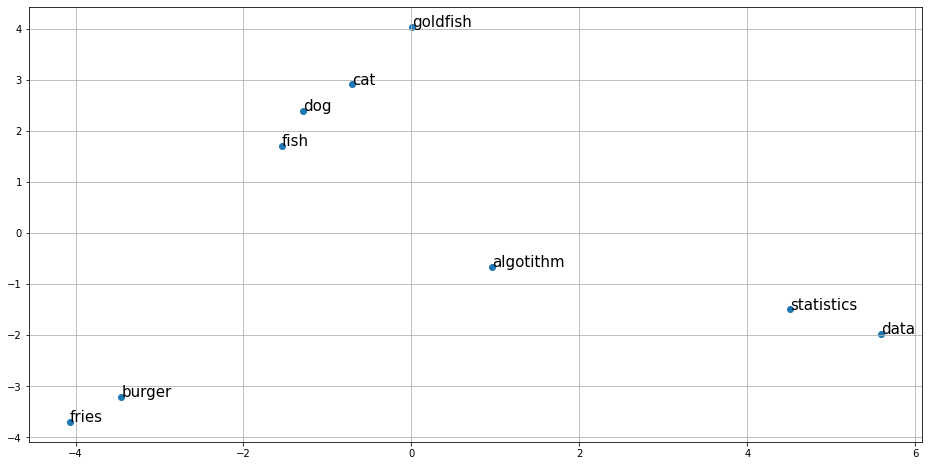

In [45]:
# create a nice big plot 
plt.figure(figsize=(16,8))

# plot the scatter plot of where the words will be
plt.scatter(word_vecs_2d[:,0], word_vecs_2d[:,1])

# for each word and coordinate pair: draw the text on the plot
for word, coord in zip(words, word_vecs_2d):
    x, y = coord
    plt.text(x, y, word, size= 15)

# show the plot
plt.grid();
plt.show()

## Challenge

You will extract word embeddings from documents using Spacy's pre-trained model in the upcoming module project. 

## Man + Woman - King = Queen 

Check out [**this article**](https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/) which explores the above equation

# Sources

* Spacy 101 - https://course.spacy.io
* NLTK Book - https://www.nltk.org/book/
* An Introduction to Information Retrieval - https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf